In [1]:
import numpy as np
import pyoscode
import matplotlib.pyplot as plt
plt.ion()
import scipy.special as sp
import scipy.integrate
from scipy.optimize import minimize_scalar
from wand.image import Image as WImage

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, IntSlider, FloatSlider,FloatLogSlider, SelectMultiple
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline


from IPython.core.display import HTML
HTML("""
<style>
.slides {
  width: 100% !important;
}
.middle > * {
  vertical-align: middle;
}


</style>
""")


In /home/fruzsina/.config/matplotlib/stylelib/paper.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fruzsina/.config/matplotlib/stylelib/paper-elsevier.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
Missing colon in file PosixPath('/home/fruzsina/.config/matplotlib/stylelib/kicc.mplstyle'), line 61 ('patch.linewidth = 0.5')


In [2]:
def wkb_step_airy(t,x,dx,h,order,n):
    
    times = np.linspace(t,t+h,n)
    ds0 = 1j*(np.sqrt(t))
    ds1 = -1./4*(t**(-1))
    ds2 = 1j*5./32*(t**(-5./2))
    ds3 = 15./64*(t**(-4.))
    s0 = 1j*2./3*((times)**(3./2)-t**(3./2))
    s1 = -1./4*np.log((times)/t)
    s2 = -1j*5./48*((times)**(-3./2)-t**(-3./2))
    s3 = -5./64*((times)**(-3)-t**(-3))
    
    alls = [s0,s1,s2,s3]
    allds = [ds0,ds1,ds2,ds3]
    fp = np.exp(sum(alls[:order+1]))
    fm = np.conj(fp)
    dfp = sum(allds[:order+1])
    dfm = np.conj(dfp)
    
    Ap = (dx - x*dfm)/(dfp - dfm)
    Am = (dx - x*dfp)/(dfm - dfp)
    
    y = Ap*fp + Am*fm
    return times,y
    

# pyoscode: fast solutions of oscillatory ODEs in physics



### Fruzsina Agocs

<img src="images/cambridge.png" width=400 align="left" style="margin: 10px 0px 30px 0px "><img src="images/caplogo.svg" width=120 align="left" style="margin: 10px 0px 30px 30px "><img src="images/kavli.jpg" width=110 align="left" style="margin: 0px 0px 0px 30px ">

<br />
<br />
<br />
<br />
<br />

To run these slides in jupyter,\
head to https://github.com/fruzsinaagocs/oscode and
<a href="https://mybinder.org/v2/gh/fruzsinaagocs/oscode/master?filepath=examples/pyoscode_scipy.ipynb">
<img src="https://mybinder.org/badge_logo.svg" align="right" width=200 style="margin: 8px 620px 0px 0px"></a>


## Introduction

- pyoscode is a numerical solver for **osc**illatory **o**rdinary **d**ifferential **e**quations
- ODEs can be oscillatory through
    - an oscillatory forcing term,  $$\ddot{x} + x = C\cos{\omega t},\; \omega \gg 1$$
    - oscillatory coefficients, $$\dot{x} = xt + 10x\cos{\omega t},\; \omega \gg 1$$
    - slowly changing, but high frequency, $$\ddot{x} + 2\gamma(t)\dot{x} + \omega^2(t) x = 0,\; \omega \gg 1$$
- oscode deals with the third type:
    - one-dimensional
    - ordinary
    - $\omega(t)$, $\gamma(t)$ vary slowly for _at least part of the integration range_

### Motivation

- all extremely common in physics: pendula, suspension, circuits, celestial mechanics, ...
- even if $\omega(t)$ changes slowly, if $\omega \gg 1$, numerical solution slow
- e.g. $\ddot{x} + tx = 0$, the Airy equation:

In [13]:
def f(t,x):
    return np.array([x[1],-t*x[0]])

ti = 1.0
tf = 1e3
x0 = np.array([sp.airy(-ti)[0], -sp.airy(-ti)[1]])

In [14]:
%%time
sol = scipy.integrate.solve_ivp(f,(ti,tf),x0,rtol=1e-3)
print(sol.success)
print("x(t={})={:.4f}, dx/dt={:.4f}".format(tf,sol.y[0][-1],sol.y[1][-1]))
print("analytic solution: x={:.4f}, dx/dt={:.4f}".format(sp.airy(-tf)[0],-sp.airy(-tf)[1]))

True
x(t=1000.0)=0.0302, dx/dt=-2.3852
analytic solution: x=0.0560, dx/dt=-2.6331
CPU times: user 1.85 s, sys: 11 µs, total: 1.85 s
Wall time: 1.85 s


- why the noticeable wall time?
    - `scipy.integrate.solve_ivp`'s default method is 4(5) order Runge-Kutta
    - Runge-Kutta excellent for non-stiff, non-oscillatory equations/regions
    - cannot deal with high-frequency oscillations (will see why)
    - the Airy frequency $\omega(t) = \sqrt{t}$, steadily increases with time

## A brief summary of the algorithm

Based on <cite data-cite="3574492/7LA4L3AM"></cite> [arxiv:1906.01421](https://arxiv.org/abs/1906.01421)

### Runge-Kutta (RK) steps 

- $\dot{\vec{x}} = F(\vec{x})$
- have (estimate of) solution $x$ at $t_i$, want to get $x$ at $t_i+h$
- Taylor expand: 

$$x(t_i+h) = x(t_i) + hF(x(t_i)) + \frac{1}{2}h^2\left.\frac{dF}{dt}\right\vert_{t=t_i} + \mathcal{O}(h^3)$$

- and replace derivatives of $F$ with evaluations of $F$ at gridpoints:

$$x(t_i+h) = x(t_i) + \sum_{j,\;t_i<t_j<t_i+h} hb_jF(x(t_j))$$

- error goes as $h^n$ $\to$ breaks down at large $h$
- approximate solution as a _polynomial_ $\to$ if $x$ oscillates, breaks down after $\approx 1$ wavelength
- small steps $\to$ more computing time
- need alternative for when solution is highly oscillatory

### Wentzel-Kramers-Brillouin (WKB) approximation

$$\ddot{x} + \omega^2(t)x = 0$$
- WKB is an _asymptotic_ expansion of the solution: $x(t) \sim Ae^{S_0(t) + S_1(t) + S_2(t) + \ldots}$ 
- $S_0 = \pm i\int{\omega dt}$ $\to$ $x(t) \sim Ae^{i\phi(t)}$ 
- $S_1 = -\frac{1}{2}\ln{\omega}$, $\to$ $x(t) \sim A(t) e^{i\phi(t)}$ 
- approximation good when $\omega$ is "slowly changing", $\left|\frac{\dot{\omega}}{\omega}\right| \ll 1$
- asymptoticity: successive terms decrease up until critical term, then increase

In [3]:
def airy_order(t0, order):
    
    t1 = t0 + 30.0
    x0 = sp.airy(-t0)[0]
    dx0 = -sp.airy(-t0)[1]
    times, sol = wkb_step_airy(t0,x0,dx0,t1-t0,order,1000)
    times_dense = np.linspace(t0,t1,1000)
    sol_dense = np.array([sp.airy(-t)[0] for t in times_dense])
    fig, ax = plt.subplots(2,1,figsize=(10,5),sharex=True)
    plt.tight_layout()
    plt.title('WKB approximation for the Airy equation, $\ddot{x} + tx = 0$')
    ax[0].plot(times_dense,sol_dense,color='black',label='analytic solution')
    ax[0].plot(times,sol,color='C1',label='WKB, order: {}'.format(order)) 
    ax[0].set_ylim(-0.6,0.6)
    ax[0].set_ylabel('$x$')
    ax[0].legend()
    ax[1].semilogy(times_dense,abs(sol-sol_dense),color='black')    
    ax[1].set_ylim((1e-7,1e-0))
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('$|\Delta x|$')
    plt.show()

interact(airy_order, 
         t0=FloatSlider(min=1.0, max=10.0, step=1.0), order=IntSlider(min=0, max=3,
                           step=1), continuous_update=False);

interactive(children=(FloatSlider(value=1.0, description='t0', max=10.0, min=1.0, step=1.0), IntSlider(value=0…

### WKB steps

- embed WKB approximation in a "stepper"
- let $f_{\pm}(t)$ be the two independent WKB solutions: 
$$ f_{+}(t) = e^{S_0+S_1+S_2+\ldots}, \; f_{-}(t) = e^{-S_0+S_1-S_2+\ldots}  $$
- then linearly combine at each step: 
$$ x(t+h) = A_{+}(t)f_{+}(t+h) + A_{-}(t)f_{-}(t+h) $$
$$ \dot{x}(t+h) = B_{+}(t)\dot{f}_{+}(t+h) + B_{-}(t)\dot{f}_{-}(t+h) $$
- this _resets_ the WKB approximation, and reduces to Euler's method in the limit $h\to 0$:
$$ x(t+h) = x(t) + h\dot{x}(t) $$
$$ \dot{x}(t+h) = \dot{x}(t) + h\ddot{x}(t) $$

### Speaker notes:

- WKB inherently one-dimensional
- notice the $\pm$ sign in WKB terms $\to$ two solutions possible
- alternate terms purely real or imaginary -> only affecting amplitude/phase

### &ldquo;RKWKB&rdquo; method

- step along the numerical solution (initial value problem solver)
- 2 components:
    - _adaptive stepsize_ : change stepsize ($h$) based on estimate of local error
    - _switching_ : between RK and WKB steps
        - whichever gives larger $h$ to keep local error within user-specified tolerance
        - use common set of function evaluations $\to$ minimum evaluations per step
- local error estimated as difference between $n^{\mathrm{th}}$ and $(n-1)^{\mathrm{th}}$ method
- details in <cite data-cite="3574492/7LA4L3AM"></cite> [arxiv:1906.01421](https://arxiv.org/abs/1906.01421)

In [4]:
n = 40.
ts1 = np.linspace(-n/2,n/2,100000)
ws1 = np.log(np.sqrt((n**2-1.)))-np.log(1+ts1**2)
gs1 = np.zeros_like(ts1)
ti1 = ts1[0]
tf_dense = ts1[-1]
xi1 = np.sqrt(1.+ti1**2)/n*np.cos(n*np.arctan(ti1))
dxi1 = 1./(n*np.sqrt(1+ti1**2))*(ti1*np.cos(n*np.arctan(ti1))-n*np.sin(n*np.arctan(ti1)))
xs_ana = np.sqrt(1.+ts1**2)/n*(np.cos(n*np.arctan(ts1))) 
solution1 = pyoscode.solve(ts1,ws1,gs1,ti1,tf_dense,xi1,dxi1,logw=True,rtol=1e-3)

def burst_f(t,y):
    return np.array([y[1],-(n**2-1.)/(1.+t**2)**2*y[0]])

def burst_rk(tf):
    
    sol = scipy.integrate.solve_ivp(burst_f,(ti1,tf),np.array([xi1,dxi1]),rtol=1e-3)
    t_rk = sol.t
    final_ind = np.argmax(t_rk >= tf)
    
    t_rk = t_rk[:final_ind+1]
    x_rk = sol.y[0][:final_ind+1]
    
    plt.figure(figsize=(10,2.5))
    plt.tight_layout()
    plt.title("scipy.integrate.solve_ivp solving the equation $\ddot{x}+\\frac{n^2-1}{(1+t^2)^2}x=0$, with $n=40$")
    plt.plot(ts1,xs_ana,label='analytic solution',color='black',lw=0.7)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.plot(t_rk,x_rk ,'.',label='RK',ms=9.0,color='C1')
    plt.legend()    

def burst(tf):
     
    t_osc = np.array(solution1['t'])
    final_ind = np.argmax(t_osc >= tf)
            
    t_osc = t_osc[:final_ind+1]
    x_osc = np.array(solution1['sol'])[:final_ind+1]
    types = np.array(solution1['types'])[:final_ind+1]
    t_rk = t_osc[types==0]
    x_rk = x_osc[types==0]
    t_wkb = t_osc[types==1]
    x_wkb = x_osc[types==1]
    plt.figure(figsize=(10,2.5))
    plt.tight_layout()
    plt.title("oscode solving the equation $\ddot{x}+\\frac{n^2-1}{(1+t^2)^2}x=0$, with $n=40$")
    plt.plot(ts1,xs_ana,label='analytic solution',color='black',lw=0.7)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.plot(t_rk,x_rk ,'.',label='RK',ms=9.0,color='C1')
    plt.plot(t_wkb,x_wkb,'.',label='WKB',ms=9.0,color='C0')
    plt.legend()
    

interact(burst, 
         tf=FloatSlider(min=ti1, max=tf_dense,
                           step=1.0, continuous_update=False, value=ti1));

interact(burst_rk, 
         tf=FloatSlider(min=ti1, max=tf_dense,
                           step=1.0, continuous_update=False, value=ti1));

interactive(children=(FloatSlider(value=-20.0, continuous_update=False, description='tf', max=20.0, min=-20.0,…

interactive(children=(FloatSlider(value=-20.0, continuous_update=False, description='tf', max=20.0, min=-20.0,…

In [5]:
def burst2(n2):
    
    ts2 = np.linspace(-n2,n2,500000)
    ws2 = np.log(np.sqrt((n2**2-1.)))-np.log(1+ts2**2)
    gs2 = np.zeros_like(ts2)
    ti2 = ts2[0]
    tf_dense = ts2[-1]
    xi2 = np.sqrt(1.+ti2**2)/n2*np.cos(n2*np.arctan(ti2))
    dxi2 = 1./(n2*np.sqrt(1+ti2**2))*(ti2*np.cos(n2*np.arctan(ti2))-n2*np.sin(n2*np.arctan(ti2)))
    xs_ana2 = np.sqrt(1.+ts2**2)/n2*(np.cos(n2*np.arctan(ts2))) 
    solution2 = pyoscode.solve(ts2,ws2,gs2,ti2,tf_dense,xi2,dxi2,logw=True,rtol=1e-3)
     
    t_osc = np.array(solution2['t'])

    oscs = np.zeros(len(t_osc))
    for i,t in enumerate(t_osc):
        if i!=0:
            oscs[i] = ((n2*np.arctan(t)/(2*np.pi))-(n2*np.arctan(t_osc[i-1])/(2*np.pi)))
        else:
            oscs[i] = None
    
    types = np.array(solution2['types'])
    t_rk = t_osc[types==0]
    t_wkb = t_osc[types==1]
    plt.figure(figsize=(10,5))
    plt.tight_layout()
    plt.title("Number of oscillations traversed per step, $\ddot{{x}}+\\frac{{n^2-1}}{{(1+t^2)^2}}x=0$, n={}".format(n2))
    plt.xlabel('t')
    plt.ylabel('$N_{\mathrm{osc}}$')
    plt.semilogy(t_osc,oscs,color='black')
    plt.semilogy(t_rk,oscs[types==0] ,'.',label='RK',ms=9.0,color='C1')
    plt.semilogy(t_wkb,oscs[types==1],'.',label='WKB',ms=9.0,color='C0')
    plt.ylim((1e-2,1e4))
    plt.legend()
    

interact(burst2, 
         n2=FloatLogSlider(base=10, min=2, max=5,
                           step=1), continuous_update=False);

interactive(children=(FloatLogSlider(value=100.0, description='n2', max=5.0, min=2.0, step=1.0), Output()), _d…

- Airy equation revisited with pyoscode (~2 s runtime with `scipy`):

In [15]:
ts = np.linspace(0,1e3,5000)
ws = np.sqrt(ts)
gs = np.zeros_like(ts)

# Initial conditions
ti = 1.0
tf = ts[-1]
x0 = sp.airy(-ti)[0]
dx0 = -sp.airy(-ti)[1]

In [16]:
%%time
pyoscode_sol = pyoscode.solve(ts,ws,gs,ti,tf,x0,dx0,rtol=1e-3)
pyosc_y = pyoscode_sol['sol']
pyosc_dy = pyoscode_sol['dsol']
print("x(t={})={:.4f}, dx/dt={:.4f}".format(tf,pyosc_y[-1],pyosc_dy[-1]))
print("analytic solution: x={:.4f}, dx/dt={:.4f}".format(sp.airy(-tf)[0],-sp.airy(-tf)[1]))

x(t=1000.0)=0.0560+0.0000j, dx/dt=-2.6292+0.0000j
analytic solution: x=0.0560, dx/dt=-2.6331
CPU times: user 534 µs, sys: 89 µs, total: 623 µs
Wall time: 482 µs


## Examples in physics

### Cosmology

- origins of large-scale structure thought to have been quantum-scale density fluctuations 
- fluctuations stretched to macroscopic scales during a period of accelerated expansion, inflation $t < \;\sim 10^{-32}$ s
- observe these today in the cosmic microwave background (CMB)
- to draw inference from the CMB about the early universe, need to forward-model evolution of perturbations
    - key quantity is the primordial power spectrum (PPS) of _gauge-invariant curvature perturbations_
    - need to assume a form of this or compute it

<img src="images/cmb.png" width=700 text-align="center" style="margin: 50px 450px">

- power spectrum: $|$amplitude$|^2$ as a function of Fourier wavenumber $k$ of perturbation
- computation of spectrum _can be_ bottleneck in forward modelling, e.g.
    - curved universes with **primordial curvature**:
        - <cite data-cite="3574492/2VK67JYP"></cite> [arxiv:1907.08524](https://arxiv.org/abs/1907.08524),
        - <cite>(Hergt, Agocs, Handley, Hobson, and Lasenby, &ldquo;Finite inflation in curved space&rdquo; in prep.)</cite>
    - axion monodromy models <cite data-cite="3574492/MC4FCNHB"></cite> [arxiv:1502.02114](https://arxiv.org/abs/1502.02114)
    - initial conditions set at very early times <cite data-cite="3574492/ZT4XDK5S"></cite> [arXiv:2002.07042](https://arxiv.org/abs/2002.07042)
- why bother evaluating new models of inflation?
    - standard model of cosmology, $\Lambda$CDM: analytic PPS
    - but: unexplained features in CMB, tension in cosmological parameters ($H_0$, $\sigma_8$)

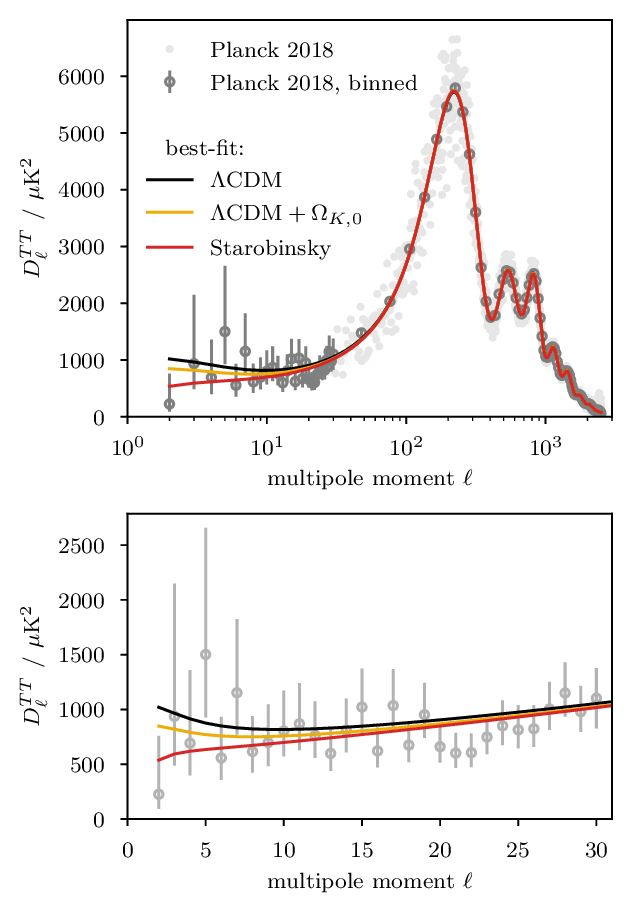

In [6]:
WImage(filename='images/bestfit_cl_tt_stb.pdf', resolution=200)

<img src=" https://github.com/fruzsinaagocs/oscode/raw/master/pyoscode/images/spectra.gif" width=700 text-align="center" style="margin: 0px 450px">

In [7]:
def horizon_plot(labels):

    times = np.linspace(-20.0,100.0,240)
    pert_scale = np.ones_like(times)*75
    horizon = np.concatenate((times[:20]+120,-times[20:120]+100.0,times[120:]+20))

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_frame_on = False    
    ax.set_ylabel('comoving scales')
    ax.set_xlabel('time ($\log{a}$)')
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.plot(times,horizon,color='black')
    ax.plot(times,pert_scale,color='C1')
    ax.text(79,76,'perturbation scale',c='C1')
    ax.text(67,118,'comoving Hubble horizon',c='black')
    ax.set_title('Calculating the primordial and processed power spectrum')
    if 'eras' in labels:
        ax.text(-17,72,'KD')
        ax.text(2,72,'inflation')
        ax.text(34.5,72,'reheating')
        ax.text(69,72,'hot Big Bang')
    if 'perturbation' in labels:
        ax.arrow(28,79,-2.2,-3,head_width=1,head_length=1,color='black') # to 27,74
        ax.arrow(52.5,79,2,-3,head_width=1,head_length=1,color='black') # to 53,74
        ax.text(21,79.5,'horizon exit')
        ax.text(40,79.5,'horizon re-entry')

        pert_times = np.linspace(-10,50,600)
        pert_xs = 90.0 + 3*np.cos(3*pert_times[:200])*np.cos(0.05*pert_times[100:300])
        ax.plot(pert_times[150:350],pert_xs,color='C1')
        eva_xs = np.exp(-0.1*(pert_times[200:400]-pert_times[200])) + 89.0
        ax.plot(pert_times[350:550],eva_xs,color='C1')   
        ax.text(0,89.0,'$\mathcal{R}_k$',c='C1',size='large')
    if 'transfer function' in labels:
        ax.text(47,88.0,'PPS')
        ax.arrow(52,89.0,33,0.0,head_width=1,head_length=1,color='black')
        ax.text(87.0,88.5,'processed PS')
        ax.text(65,90.0,'$T(k)$')
        
    #plt.legend()
    plt.show()


interact(horizon_plot, 
         labels=SelectMultiple(
        options=['eras', 'perturbation', 'transfer function'],
        value=[],
        #rows=10,
        #description='Fruits',
        disabled=False), 
        continuous_update=False);




interactive(children=(SelectMultiple(description='labels', options=('eras', 'perturbation', 'transfer function…

- need time-evolution of gauge-invariant curvature perturbations of wavenumber $k$:
    - Mukhanov-Sasaki equation (assuming spatially flat universe, single-field inflation)
    $$ \ddot{\mathcal{R}}_k + 2\left( \frac{\ddot{\phi}}{\phi} -\frac{1}{2} \dot{\phi}^2 + \frac{3}{2}\right)\dot{\mathcal{R}}_k + \left( \frac{k}{aH} \right)^2\mathcal{R}_k = 0 $$
    - $a$: scale factor, $H$: Hubble parameter, $\phi$: inflaton field
    - using $N = \ln{a}$ as independent variable
    - oscillator with time-dependent frequency and damping
    - frequency $\propto k \to$ can get large, computationally challenging
    - $\omega$, $\gamma$ not closed-form functions
    

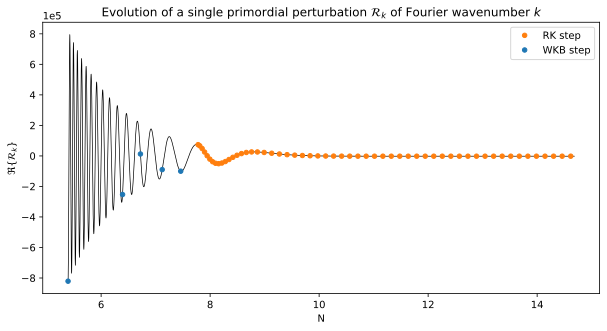

In [8]:
import re

pair = re.compile(r'\(([^,\)]+),([^,\)]+)\)')
def parse_pair(s):
    s = s.decode('utf-8')
    return complex(*map(float, pair.match(s).groups()))

f1 = "images/bingo-singlek-k1e-5.txt"
f1ref = "images/bingo-singlek-k1e-5-ref.txt"
f1wkb = "images/rkwkb-single-k1e-5.txt"
d1 = np.genfromtxt(f1)
d1ref = np.genfromtxt(f1ref)
d1wkb = np.genfromtxt(f1wkb,dtype=complex,converters={1:parse_pair, 2:parse_pair})
n1 = d1[:,0]
n1ref = d1ref[:,0]
n1wkb = d1wkb[:,0]
rk1 = d1[:,1]
rk1ref = d1ref[:,1]
rk1wkb = d1wkb[:,1]
rk1steps = d1wkb[:,3]

plt.figure(figsize=(10,5))
plt.title('Evolution of a single primordial perturbation $\mathcal{R}_k$ of Fourier wavenumber $k$')
plt.plot(n1ref,rk1ref,color='black',lw=0.7)
plt.plot(n1wkb[rk1steps==0],rk1wkb[rk1steps==0],'.',color='C1',ms=9.0,label='RK step')
plt.plot(n1wkb[rk1steps==1],rk1wkb[rk1steps==1],'.',color='C0',ms=9.0,label='WKB step')
plt.ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
plt.legend()
plt.xlabel('N')
plt.ylabel('$\Re{\{ \mathcal{R}_k \}} $')
plt.show()


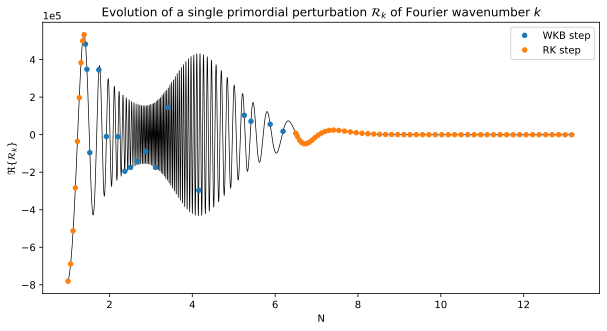

In [9]:
fs1 = "images/singlek-kd-bd-2a.txt"
fs2 = "images/singlek-kd-bd-2a.txt"
fref = "images/singlek-kd-bg-2a-ref.txt"
d1 = np.genfromtxt(fs1,dtype=complex,converters={1:parse_pair,2:parse_pair,4:parse_pair})
d2 = np.genfromtxt(fs2,dtype=complex,converters={1:parse_pair,2:parse_pair,4:parse_pair})
dref = np.genfromtxt(fref)
n1 = d1[:,0]
n2 = d2[:,0]
nref = dref[:,0]
rk1 = d1[:,1]
rk2 = d2[:,1]
rkref = dref[:,1]
wkb1 = d1[:,3]
wkb2 = d2[:,3]
plt.figure(figsize=(10,5))
plt.title('Evolution of a single primordial perturbation $\mathcal{R}_k$ of Fourier wavenumber $k$')
plt.plot(nref,rkref,color='black',lw=0.7)
plt.plot(n1[wkb1==1],(rk1[wkb1==1]),'.',color='C0',label='WKB step',ms=9.)
plt.plot(n1[wkb1==0],(rk1[wkb1==0]),'.',color='C1',label='RK step',ms=9.)
plt.ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
plt.xlabel('N')
plt.ylabel('$\Re{\{ \mathcal{R}_k \}} $')
plt.legend()
plt.show()
 

### Universes with primordial curvature

- based on _(Hergt, Agocs, Handley, Hobson, and Lasenby, “Finite inflation in curved space”, in prep.)_
- non-zero spatial curvature affects perturbation growth/CMB anisotropy spectrum on two levels:
    1. Curvature terms enter in hot Big Bang evolution 
        - modified transfer functions $T(k)$
        - extend base ΛCDM model (standard model of cosmology) with a variable present-day curvature density parameter $\Omega_{K,0}$
        - i.e. Mukhanov-Sasaki equation unaffected, analytic PPS
    2. Limits the amount of inflation
        - affects the PPS $\to$ account for unexplained features in CMB spectra?
        - curvature is a parameter in the Mukhanov-Sasaki equation _already_
        - need fully numerical primordial power spectra
        

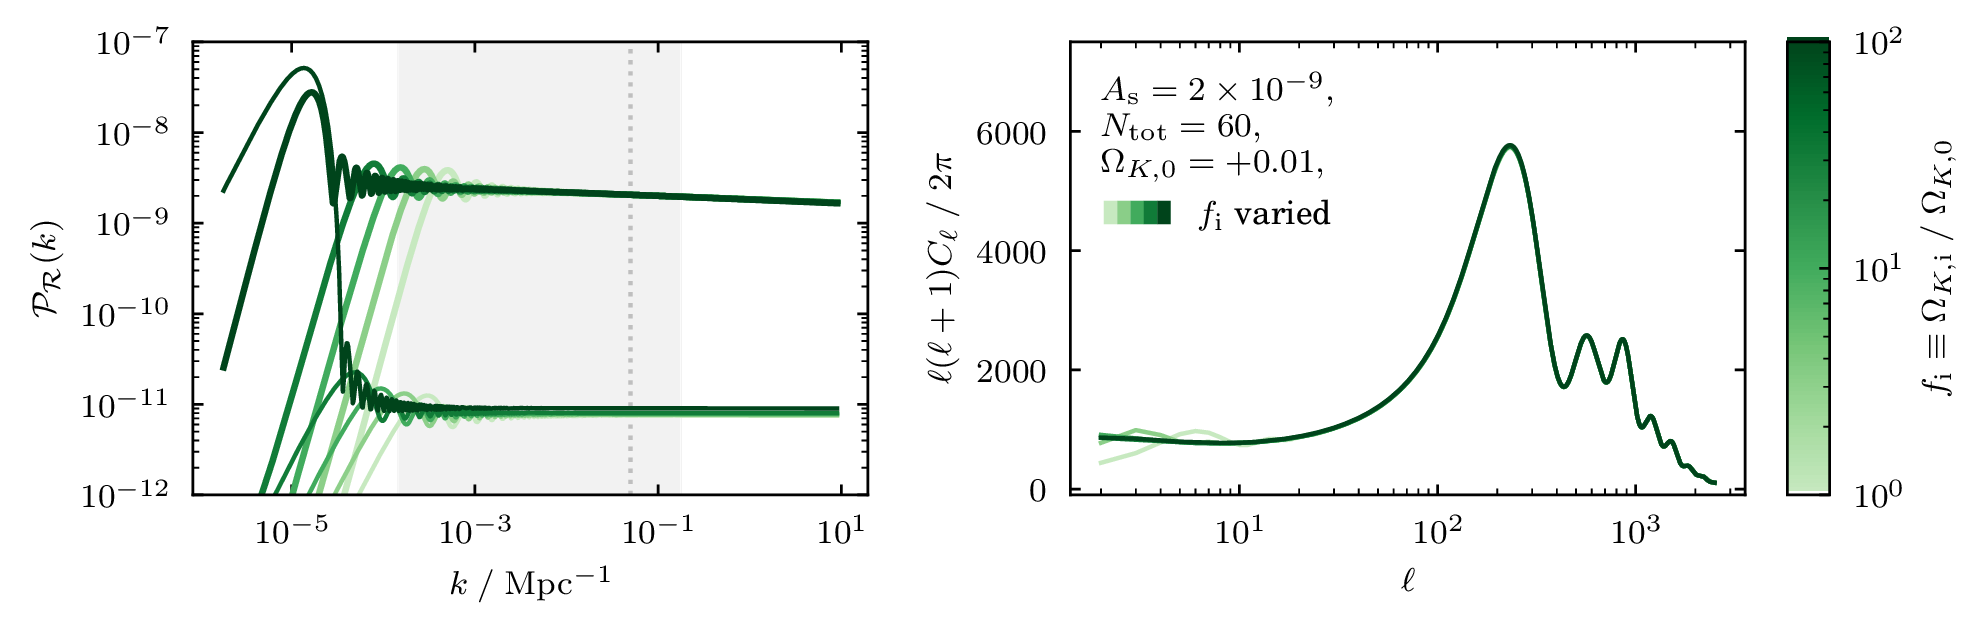

In [10]:
WImage(filename="images/open_pps_cls_green.pdf", resolution=300)

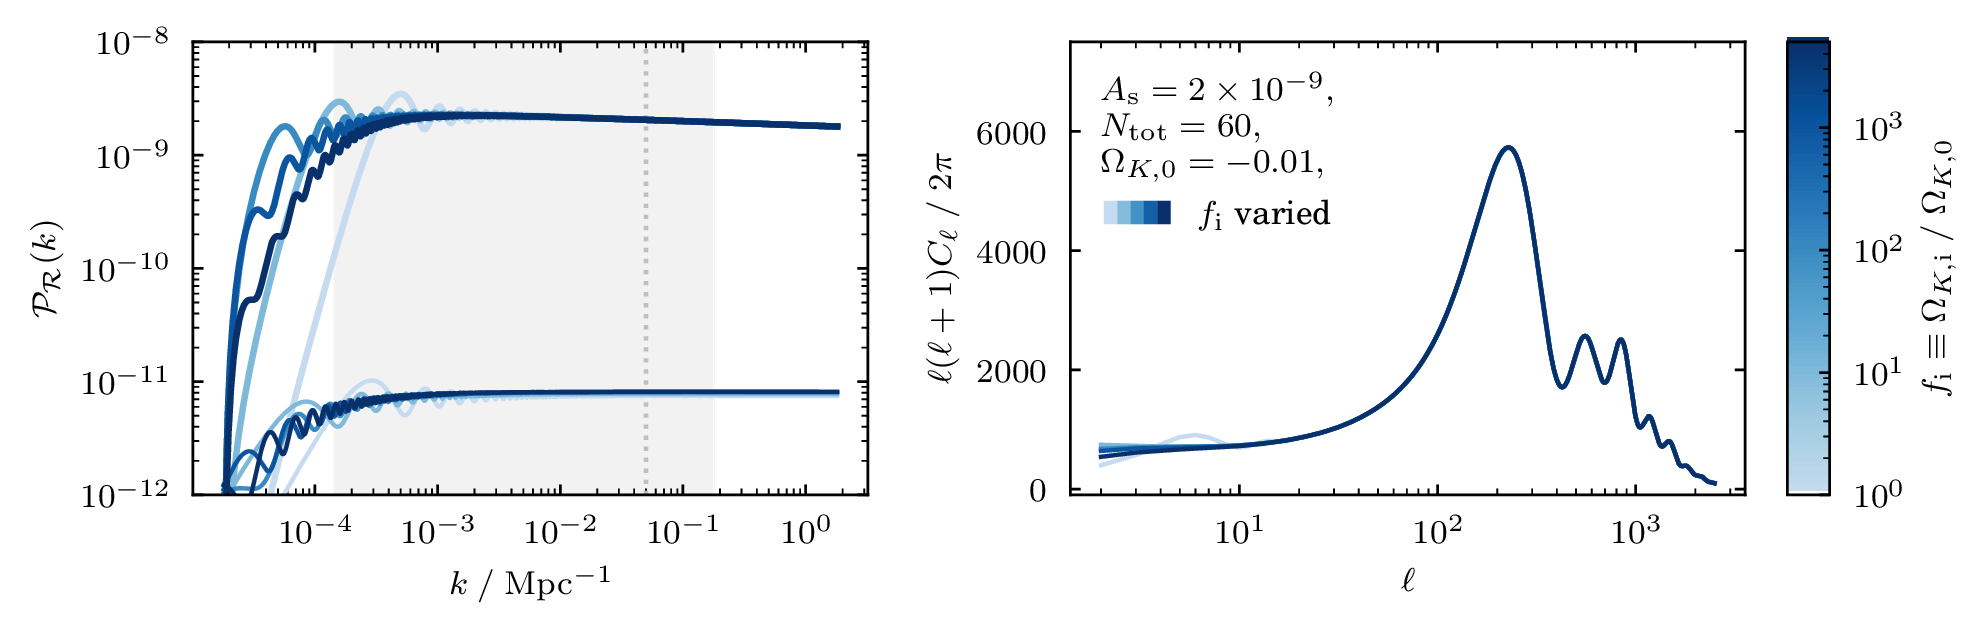

In [11]:
WImage(filename="images/closed_pps_cls_blue.pdf", resolution=300)

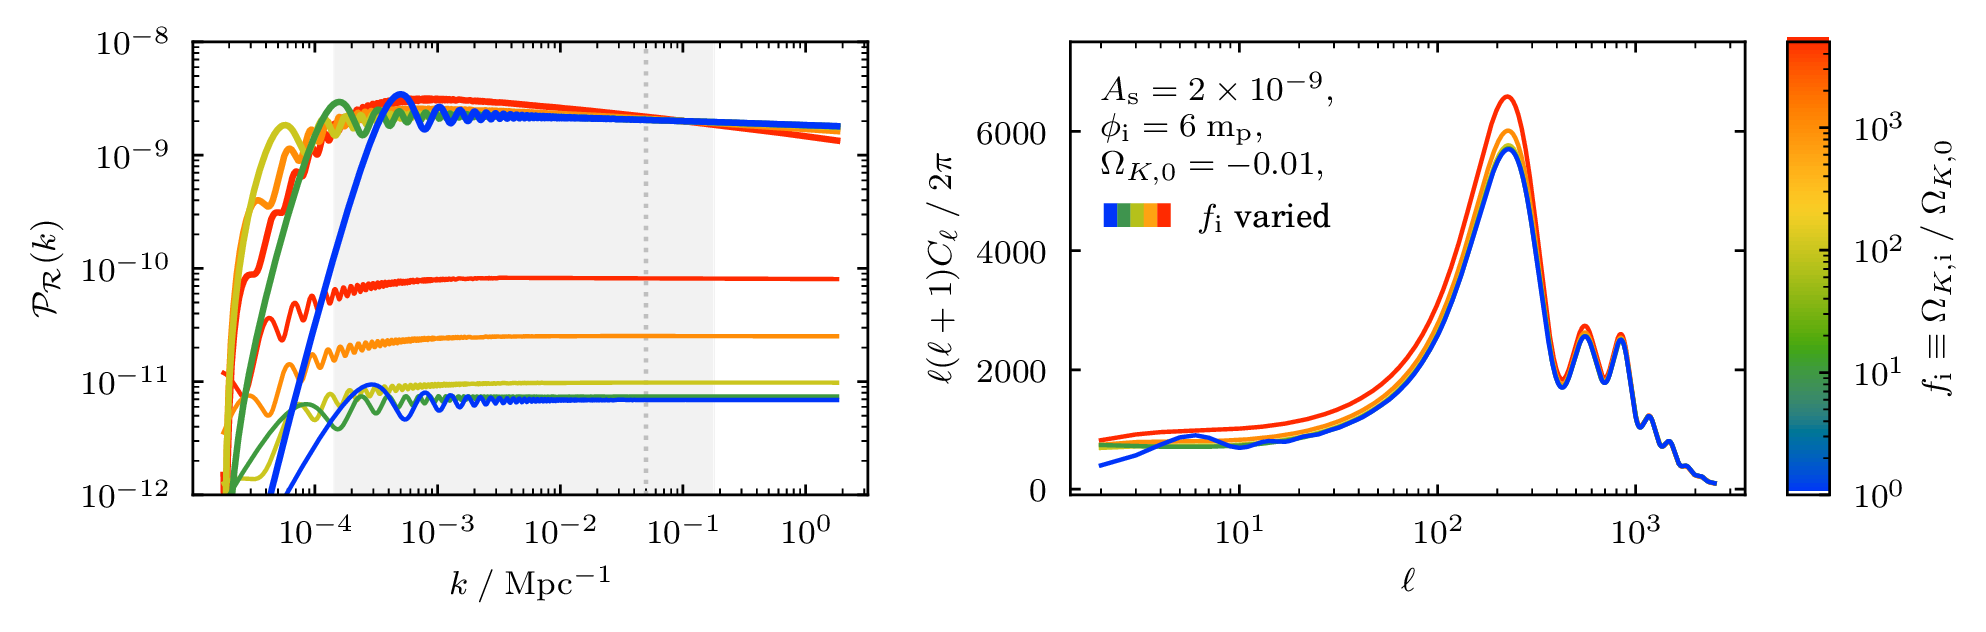

In [12]:
WImage(filename="images/closed_pps_cls_rainbow.pdf", resolution=300)

### Quantum mechanics

- time-independent, one-dimensional Schrödinger equation: 

$$ \Psi''(x) + 2m(E-V(x))\Psi(x) = 0 $$

- $\Psi$ is wavefunction, $V(x)$ potential well, $E$ are _unknown_ energy eigenvalues of the system to be determined
- a harmonic oscillator with time-dependent frequency that can be real or imaginary
- a _boundary value problem_ :
    - continuity of $\Psi$ and $\Psi'$ required at edges of potential well where $E = V(x)$
    - $\Psi(x)\to 0$ far outside the well where $V(x) \gg E$ 

- can rephrase as optimisation problem:
    - guess lower and upper bound for $n^{\mathrm{th}}$ eigenvalue $E_n$
    - start from initial guess for $E_n$ within bounds
    - propagate two solutions from outside the potential well ( _initial value problems_ )
    - check for continuity between two solutions, $\Psi_L$ and $\Psi_R$, at midpoint
    - eigenvalue found when $\left\vert\frac{\Psi_L'}{\Psi_L}-\frac{\Psi_R'}{\Psi_R}\right\vert = 0$

- Try potential of the form $V(x) = x^2 + \lambda x^4$, the anharmonic oscillator
- $\lambda=1$, find $n^{\mathrm{th}}$ energy levels with $n=\{$50, 100, 1000, 10000$\}$ 
- Numerical values using a conventional method: $E_n=$ 417.05626, 1035.5442, 21932, 7840, 471103.80 <cite data-cite="3574492/5I6RED6P"></cite>

Eigenenergy found: 416.60834468082714
Eigenenergy found: 1035.3995965810213
Eigenenergy found: 21939.980473898962
Eigenenergy found: 471103.8196601125


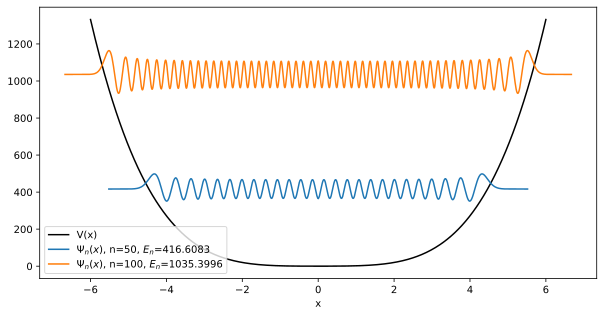

In [17]:
l=1.0
m=0.5

def Ei(n):
    """ 
    Energy eigenvalues (if analytic solution available)
    """
    return np.sqrt(2.0)*(n-0.5)

def V(t):
    """ 
    Potential well 
    """
    return t**2 + l*t**4

def w(t,E):
    """
    Frequency term in the Schrodinger equation
    """
    return np.sqrt(2*m*(complex(E)-V(t)));

def f(E):
    """
    Function to minimize wrt E to give the energy eigenvalues
    """

    # Boundaries of integration
    tl = -((E)**(0.25))-2.0
    tr = -tl
    tm = 0.5

    # Grid of w, g
    t = np.linspace(tl.real,tr.real,30000)
    ws = np.log(w(t,E))
    g = np.zeros(t.shape)
    sol_l = pyoscode.solve(t,ws,g,tl,tm,0,1e-3,logw=True,rtol=1e-5)
    sol_r = pyoscode.solve(t,ws,g,tr,tm,0,1e-3,h=-1,logw=True,rtol=1e-5)
    psi_l = sol_l["sol"][-1]
    psi_r = sol_r["sol"][-1]
    dpsi_l = sol_l["dsol"][-1]
    dpsi_r = sol_r["dsol"][-1]
    try:
        return abs(dpsi_l/psi_l - dpsi_r/psi_r)
    except ZeroDivisionError:
        return 1000.0
    
def plot(ns,Es):

    plt.figure(figsize=(10,5))
    t_v = np.linspace(-6,6,500)
    plt.plot(t_v,V(t_v),color='black',label='V(x)')

    for j,n,E in zip(range(len(ns)),ns,Es):
        # Boundaries of integration
        tl = -((E)**(0.25))-1.0
        tr = -tl
        tm = 0.0

        # Grid of w, g
        t = np.linspace(tl.real,tr.real,30000)
        ws = np.log(w(t,E))
        g = np.zeros(t.shape)

        sol_l = pyoscode.solve(t,ws,g,tl,tr/2.,0,1e-3,logw=True,rtol=1e-5)
        x_l = sol_l['sol']
        ts_l = sol_l['t']
        types_l = sol_l['types']
        for i,typ in enumerate(types_l):
            if typ==1 and 0 not in types_l[i:]:
                firstwkb = i
                break;



        t_eval = np.linspace(ts_l[firstwkb],tm,2000)
        sol = pyoscode.solve(t,ws,g,tl,tr,0,1e-3,logw=True,rtol=1e-5,t_eval=t_eval)

        x_eval = sol['x_eval']
        x_l = x_l[:firstwkb]
        ts_l = ts_l[:firstwkb]
        Ts_l = np.concatenate((np.array(ts_l),t_eval))
        Xs_l = np.concatenate((np.array(x_l),x_eval))
        maxx = max(np.real(Xs_l))
        Xs_l = Xs_l/maxx*4*np.sqrt(E)
        plt.plot(Ts_l,Xs_l+E,color='C{}'.format(j),label='$\Psi_n(x)$, n={}, $E_n$={:.4f}'.format(n,E))
        plt.plot(-1*Ts_l,Xs_l+E,color='C{}'.format(j))
    plt.xlabel('x')
    plt.legend(loc='lower left')
    plt.show()

bounds = [ (416.5,417.5),(1035,1037),(21930,21940),(471100,471110)]

ress = []
for bound in bounds:
    res = minimize_scalar(f,bounds=bound,method='bounded')
    print("Eigenenergy found: {}".format(res.x))
    ress.append(res.x)
plot([50,100],ress[:2])


### Other examples

- modelling the mechanics of the cochlea <cite data-cite="3574492/5BZSXUB8"></cite> [doi:10.1155/2014/150637](https://doi.org/10.1155/2014/150637)
    - cochlea map sounds of different frequencies onto unique positions on the basilar membrane
- normal modes in black holes <cite data-cite="3574492/LYQIAQKR"></cite> [doi:10.1103/PhysRevD.35.3632](https://doi.org/10.1103/PhysRevD.35.3632)
    - resonant, nonradial perturbations of black holes caused by external perturbations
- scattering of radio waves from overdense meteor trains <cite data-cite="3574492/8WK2IYN7"></cite> [doi:10.1016/0032-0633(92)90045-P](https://doi.org/10.1016/0032-0633(92)90045-P)
    - symmetry allows radio waves to be decomposed into partial waves, apply WKB to each

## The interface

- draws from `scipy.integrate.solve_ivp(fun, t_span, y0, ...)`
    - `fun`: defines differential equation
    - `t_span`: integration range
    - `y0`: initial conditions
- minimal setup:

In [18]:
import numpy as np
import scipy.special as sp
import pyoscode

# Set up differential equation: x'' + tx = 0.  
ts = np.linspace(0,40.0,5000)
ws = np.sqrt(ts)
gs = np.zeros_like(ts)

# Initial conditions
ti = 1.0
tf = 40.0
x0 = sp.airy(-ti)[0]
dx0 = -sp.airy(-ti)[1]

solution = pyoscode.solve(ts, ws, gs, ti, tf, x0, dx0)
solution.keys()  

dict_keys(['sol', 'dsol', 't', 'types', 'x_eval'])

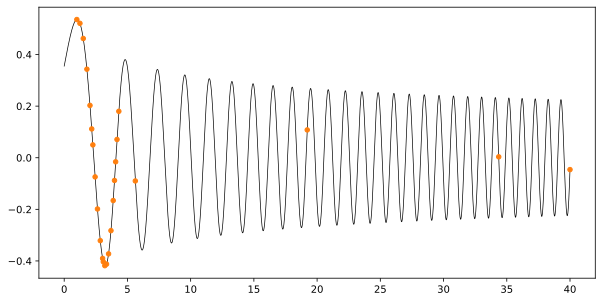

In [19]:
# Compute analytic solution for comparison
analytic = np.array([sp.airy(-t)[0] for t in ts])

plt.figure(figsize=(10,5))
plt.plot(ts,analytic,label='analytic solution',color='black',lw=0.7)
plt.plot(solution['t'],solution['sol'],'.',color='C1',label='pyoscode',ms=9.0)
plt.show()

- optional arguments allow _dense output_ 
    - output solution at user-specified points
    - no extra steps or evaluations of the RHS of the ODE $\to$ computationally cheap 
    - not trivial for highly oscillatory solutions <cite data-cite="3574492/BS7RFP2G"></cite>

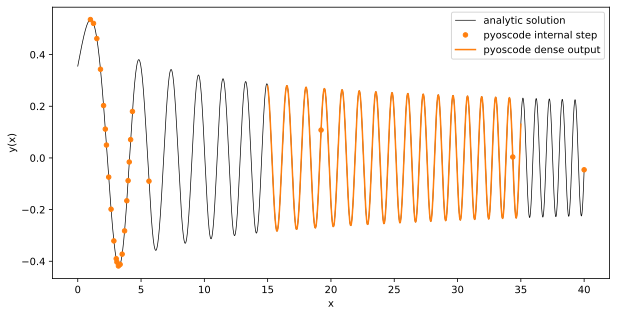

In [21]:
# We'll get the solution at these points
t_eval = np.linspace(15,35,600)
dense_solution = pyoscode.solve(ts, ws, gs, ti, tf, x0, dx0, t_eval=t_eval)

plt.figure(figsize=(10,5))
plt.plot(ts,analytic,label='analytic solution',color='black',lw=0.7)
plt.plot(dense_solution['t'],dense_solution['sol'],'.',color='C1',label='pyoscode internal step',ms=9.0)
plt.plot(t_eval, dense_solution['x_eval'], color='C1', label='pyoscode dense output')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.show()

### Documentation

- https://github.com/fruzsinaagocs/oscode
- open source software, BSD 3-clause license
- python & C++ documentation at https://oscode.readthedocs.io
- examples available for both interfaces
[![status](https://joss.theoj.org/papers/d4c9396ef9b2b595e2f3881a4f8a7cda/status.svg)](https://joss.theoj.org/papers/d4c9396ef9b2b595e2f3881a4f8a7cda)

### Extending pyoscode

- multiple, coupled oscillators
    - modified Magnus expansion instead of (inherently 1D and single-oscillator) WKB by <cite data-cite="3574492/9XNWYLFA"></cite> [arxiv:1907.11638](https://arxiv.org/abs/1907.11638)
    - more work under way <cite>(Schöneberg and Agocs, &ldquo;Beyond the traditional WKB approximation of Boltzmann equations&rdquo; in prep.)</cite>
- adapt basis function $f_{\pm}$ to problem in question:
    - WKB is suitable for highly oscillatory solutions with slowly changing frequencies
    - different basis may be suitable for e.g. a problem exhibiting sawtooth-shaped oscillations
- adjust order of WKB expansion on the fly
- _Bremer & Rokhlin's phase function approach_
- "Think globally, act locally" <cite data-cite="3574492/LL685AI2"></cite>

### Bremer & Rokhlin's phase function approach

- based on <cite data-cite="3574492/2CAMSIMG"></cite>, <cite data-cite="3574492/DMEWZXFD"></cite>
- set out to solve on $(a,b)$ $$y'' + \lambda^2 q(x) y = 0$$
by finding _non-oscillatory phase function_ $\alpha(x)$ s.t.
$$\frac{\cos{\alpha{x}}}{\sqrt{\alpha'(x)}},\;  \frac{\sin{\alpha{x}}}{\sqrt{\alpha'(x)}}$$
form a basis in the space of solutions
- for this, need to solve 3rd order nonlinear ODE for $\alpha$, _Kummer's equation_
$$r'' - \tfrac{1}{4}(r')^2 + 4\lambda^2(e^r - q) = 0$$ with $\alpha = \int_a^x e^{\tfrac{r(u)}{2}}du$

- a non-oscillatory $\alpha(x)$ that solves Kummer's equation exactly _may not exist_
- but: if $q(x)$ is non-oscillatory, there exists an approximate solution to within $$\mathcal{O}\left((\mu\lambda)^{-1}e^{-\mu\lambda}\right)$$ with $\mu$ a function of $q(x)$ but **not** $\lambda$ $\to$ gets better at high frequencies
- $r(x), \alpha(x)$ approximated well by e.g. Chebyshev polynomials with # of terms independent of $\lambda$ $\to$ $\mathcal{O}(1)$ terms
- c.f. with super-, hyperasymptotic methods: $\mathcal{O}(\lambda)$ terms, $\mathcal{O}(e^{-\rho\lambda})$ accuracy 

| pyoscode | phase functions |
| :- | :- |
| + valid at high frequencies & slowly-changing regions of solution | - accuracy gets worse at low frequencies |
| - can have messy growth of terms  | + no messy growth of terms |
| - controls local error  | + good handle on global error |
| + can deal with friction term |  0 eq. must be transformed to frictionless form (but it always can be) |
| + Python/C++  | - Fortran (sorry) |

- **Decision:**  Combine the two methods

## Thank you, questions welcome!

### References
<div class="cite2c-biblio"></div>